In [1]:
%autosave 0

Autosave disabled


# 4. Evaluation Metrics For Classification

In the previous session we trained a model for predicting churn. How do we know if it's good?

## 4.1 Evaluation metrics: Session Overview

- Dataset: https://www.kaggle.com/blastchar/telco-customer-churn
- https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv

**Metric - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are*

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

%matplotlib inline

Following steps we have already implemented and understood in the session 3:

In [3]:
# Load data
df = pd.read_csv('../03-classification/churn-data.csv')

# Clean column names
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Extract categorical column names from df
categorical_columns = df.select_dtypes('object').columns.tolist()

# Clean values in the categorical_columns
for col in categorical_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')
    
# Convert column totalcharges to numeric
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')

# Fill missing values of totalcharges with 0
df.totalcharges = df.totalcharges.fillna(0)

# Convert target variable churn from bool to binary integer
df.churn = (df.churn == 'yes').astype(int)

In [4]:
# Split 80% train and 20% test sets
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

# Split 60% train and 20% validation sets
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# Reset indexes
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Create target variable for train/val/test
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

# Delete target valriable churn from features
del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
# Create list of numeric and categorical columns (exclude customerid)
# note: seniorcitizen column is categorical
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = ['gender', 'seniorcitizen', 'partner',
               'dependents', 'phoneservice', 'multiplelines',
               'internetservice', 'onlinesecurity', 'onlinebackup',
               'deviceprotection', 'techsupport', 'streamingtv',
               'streamingmovies', 'contract', 'paperlessbilling',
               'paymentmethod']

In [6]:
# Instantiate DictVectorizer(sparse=False)
dv = DictVectorizer(sparse=False)

# Convert df_train to dictionary
train_dict = df_train[categorical + numerical].to_dict(orient='records')

# Transform and fit train_dict using dv
X_train = dv.fit_transform(train_dict)

# Create model and fit the model to train
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [7]:
# Convert validation from dataframe to dictionary
val_dict = df_val[categorical + numerical].to_dict(orient='records')

# Transform data
X_val = dv.transform(val_dict)

# Make prediction
y_pred = model.predict_proba(X_val)[:, 1]

# Calculate model accuracy
churn_decision = y_pred >= 0.5
(y_val == churn_decision).mean()

0.8034066713981547

## 4.2 Accuracy and Dummy Model

- Evaluate the model on different thresholds
- Check the accuracy of dummy baselines

In [8]:
# Calculate the accuracy of the model again
(y_val == churn_decision).mean()

0.8034066713981547

We can see the model accuracy is 80% when the threshold is `0.5`. Basically, the accuracy is measured by calculating the `correct predictions` divided by `total number of predictions`. Let's manually apply the accuracy below:

In [9]:
correct_preds = (y_val == churn_decision).sum()
total_preds = len(churn_decision)

correct_preds / total_preds

0.8034066713981547

Indeed we get the same accuracy. We can also accuracy the accuracy using sklearn.

In [10]:
from sklearn.metrics import accuracy_score

accuracy_score(y_val, churn_decision)

0.8034066713981547

By default, logistic regression uses 0.5 threshold to optimize the results for accuracy. Let's see what happens when we calculate the accuracy on different thresholds, for that we'll create a dummy model for evaluation.

In [11]:
# Create an array of 21 different thresholds between 0 and 1 
thresholds = np.linspace(0, 1, 21)

# List to store accuracy
scores = []
for t in thresholds:
    churn_decision = y_pred >= t
    score = accuracy_score(y_val, churn_decision)
    scores.append(score)
    print(f'{t:.2f} - {score:.3f}')

0.00 - 0.274
0.05 - 0.509
0.10 - 0.591
0.15 - 0.666
0.20 - 0.710
0.25 - 0.739
0.30 - 0.760
0.35 - 0.772
0.40 - 0.785
0.45 - 0.793
0.50 - 0.803
0.55 - 0.801
0.60 - 0.795
0.65 - 0.786
0.70 - 0.765
0.75 - 0.744
0.80 - 0.735
0.85 - 0.726
0.90 - 0.726
0.95 - 0.726
1.00 - 0.726


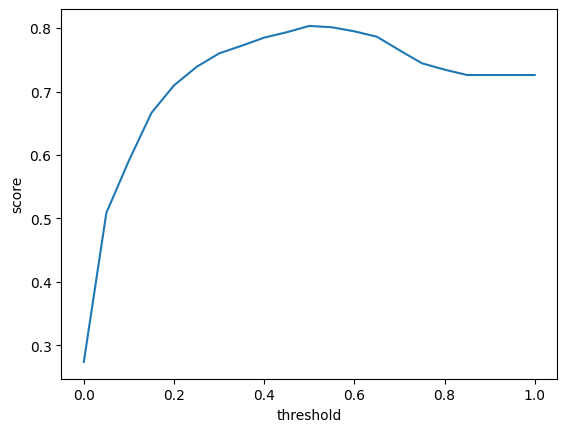

In [12]:
# Plot the thresholds and scores
plt.plot(thresholds, scores)
plt.xlabel('threshold')
plt.ylabel('score')
plt.show();

As we can see the best accuracy is at threshold 0.5. But what this graph actually tells us? To answer that, let's look at the distribution of the prdictions when the threshold is 1.0.

In [13]:
from collections import Counter

# Count customers distribution for churn and not churn on predictions
Counter(y_pred >= 1.0)

Counter({False: 1409})

Predictions at the threshold 1.0 tells us that no customer is going to churn (`1409 total number of customer`) but when we look at the actual values (y_val) the distribution is different.

In [14]:
# Count customers distribution for churn and not churn on validation
Counter(y_val)

Counter({0: 1023, 1: 386})

The actual values tell us that 1023 customers did not churn and 386 churned.

So, the dummy model predicts at threshold 1.0 no customer will churn and it gives us the accuracy of approximately 73% accuracy, which makes the difference of only 7% compare to the original model (80%). Therefore, accuracy metric can't exactly tells us how good is our model and that's because our data has imbalance classes with the ratio of 3:1. 

These results will be misleading, hence, we need other metrics for model evaluation.

## 4.3 Confusion Table

- Different types of errors and correct decisions
- Arranging them in a table

Confusion table tells us how many prediction our model has made correct and how many it has made incorrect. For binary classification classifier, there are possiblities that can happen in terms of predictions:

- Churn (Positive class)
    - Customer churned (TP)
    - Customer did not churn (FP)
- Not churn (Negative class)
    - Customer churned (TN)
    - Customer did not churn (FN)
    
Confusion table is helpful to analysis the quality of the model and how close it is making predictions to the acutal values. We can make the confusion table in numpy in the following way:

In [15]:
# Create arrays to represent actual class labels
actual_positive = y_val == 1
actual_negative = y_val == 0

In [16]:
# Create arrays to represent predicted class labels
t = 0.5 # threshold
predict_positive = y_pred >= t
predict_negative = y_pred < t

Now we have the actual and predicted class labels, we can combine them to derive tp, tn, fp, and fn:

In [17]:
# Calculate number of true positive class labels
tp = (predict_positive & actual_positive).sum()
# Calculate number of true negative class labels
tn = (predict_negative & actual_negative).sum()

# Calculate number of false positive class labels
fp = (predict_positive & actual_negative).sum()
# Calculate number of false negative class labels
fn = (predict_negative & actual_positive).sum()

In [18]:
# Create confusion matrix
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])

confusion_matrix

array([[922, 101],
       [176, 210]])

We can get the ratio of these values by dividing confusion matrix with its sum.

In [19]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

As we have talked about it earlier the accuracy, it is the correct predictions (tn + tp) that our model made. The confusion matrix is telling us exactly that (`65% + 15% = 80%`), and that was indeed the model predictions. We can calculate the accuracy using the formula:

$$\frac{TN + TP}{TN + TP + FN + FP}$$

In [20]:
# Calculate accuracy
acc = (tn + tp) / (tn + tp + fn + fp)
acc.round(2)*100

80.0

## 4.4 Precision and Recall

If we consider the problem we have in hand, we can say that:
- **Precision**: Among all the customers classified by the model as potential churn, the fraction of that ended up to churned
- **Recall**: Among all the customers that ended up to be churned, the fraction of that the model correctly classified

Precision is the fraction of TP divided by TP + FP, therefore it only consider positive labels: 

$$\frac{TP}{TP + FP}$$

Recall is the fraction of TP divided by TP + FN:

$$\frac{TP}{TP + FN}$$

Let's see how we can calculate them:

In [21]:
# Calculate precision
p = tp / (tp + fp)
p.round(2)

0.68

We get the precision of 68% and what that means it 22% of the customer who were not going to churn but got the promotion.

In [22]:
# Calculate recall
r = tp / (tp + fn)
r.round(2)

0.54

Recall is 54% which means our model failed to identify 46% of customer who are churning.

Precision and recall give us the complete picture of the model performance and that's why making assumption on the basis of accuracy can be misleading due to imbalance class distribution.

## 4.5 ROC Curves

### FRP and TPR of the model

ROC curves (Receiver Operating Characteristic) measures two things:

- FPR: false positive rate is the fraction of FP divided by total number of TN and FP. We want to minimize the FPR.
- TPR: true positive rate is the fraction of TP divided by total number of FN and TP. We want to maximize the TPR. Note, TPR is the recall in the confusion matrix.

The formulas of FPR and TPR are followed as:

$$FPR = \frac{FP}{TN + FP}$$

$$TPR = \frac{TP}{FN + TP}$$

Using calulate FPR and TRP using the above formulas:

In [23]:
# Calculate FPR
fpr = fp / (tn + fp)
fpr

0.09872922776148582

The above ratio tells us that the model failed predict about 10% of the negative class.

In [24]:
# Calculate TPR
tpr = tp / (fn + tp)
tpr

0.5440414507772021

This shows that model missed 46% of the positive class.

The above results are drived when the threshold was 0.5. Let's calculate the FPR and TPR for 101 different thresholds and plot the results.

In [25]:
# List to store values of thresholds, tp, fp, fn, and tn
scores = []

# Array of 101 thresholds between 0 and 1
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    # actual class labels
    actual_positive = y_val == 1
    actual_negative = y_val == 0
    
    # predicted class labels
    predict_positive = y_pred >= t
    predict_negative = y_pred < t
    
    # number of true positives and true negatives
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    # number of false positives and false negatives
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn)) # tuple

In [26]:
# Convert scores list to dataframe
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,threshold,tp,fp,fn,tn
0,0.00,386,1023,0,0
1,0.01,385,913,1,110
2,0.02,384,830,2,193
3,0.03,383,766,3,257
4,0.04,381,715,5,308
...,...,...,...,...,...
96,0.96,0,0,386,1023
97,0.97,0,0,386,1023
98,0.98,0,0,386,1023
99,0.99,0,0,386,1023


In [27]:
# Create columns for tpr and fpr
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
df_scores

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.00,386,1023,0,0,1.000000,1.000000
1,0.01,385,913,1,110,0.997409,0.892473
2,0.02,384,830,2,193,0.994819,0.811339
3,0.03,383,766,3,257,0.992228,0.748778
4,0.04,381,715,5,308,0.987047,0.698925
...,...,...,...,...,...,...,...
96,0.96,0,0,386,1023,0.000000,0.000000
97,0.97,0,0,386,1023,0.000000,0.000000
98,0.98,0,0,386,1023,0.000000,0.000000
99,0.99,0,0,386,1023,0.000000,0.000000


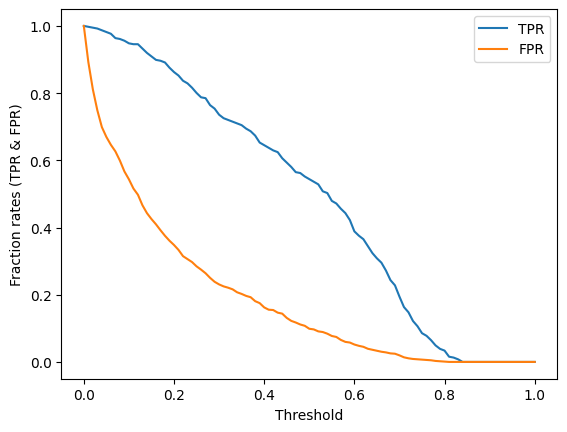

In [28]:
# Plot model tpr and fpr scores
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.xlabel('Threshold')
plt.ylabel('Fraction rates (TPR & FPR)')
plt.legend()
plt.show()

The graph above telling us when the threshold is 0, both TPR and FPR are 100%. Means the model is predicting everything correctly for positives class (churning) and negatives class (not churning). Then as the threshold increases both TPR and FPR decrease as well (remember we want to minimize FPR and maximize TPR).

So now we have some insights how the model is performing but that's not enough we need something to comparision. For that we'll create two models `random model` and `ideal model`.

### Random model

For random model, we'll create an array `y_rand_pred` as predictions using `np.random.uniform(0, 1, size=len(y_val))`:

In [29]:
# Create y_rand_pred
y_rand_pred = np.random.uniform(0, 1, size=len(y_val))
y_rand_pred

array([0.54770863, 0.85521635, 0.21995507, ..., 0.04777491, 0.93268859,
       0.32357297])

Now, we evaluate the `y_rand_pred` on `y_val` with 0.5 threshold.

In [30]:
# Evaluate y_rand_pred on y_val
((y_rand_pred >= 0.5) == y_val).mean()

0.49467707594038324

50% accuracy tells us that random model is not very useful predicting customers who are going to churn or not.

Let's create a function `tpr_fpr_dataframe()` that takes actual values and predictions to compute model TPR and FPR.

In [31]:
def tpr_fpr_dataframe(y_val, y_pred):
    # List to store values of thresholds, tp, fp, fn, and tn
    scores = []

    # Array of 101 thresholds between 0 and 1
    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        # actual class labels
        actual_positive = y_val == 1
        actual_negative = y_val == 0

        # predicted class labels
        predict_positive = y_pred >= t
        predict_negative = y_pred < t

        # number of true positive and true negative
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        # number of false positive and false negative
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn)) # tuple
        
    # Convert scores list to dataframe
    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    # Create columns for tpr and fpr
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [32]:
# Create dataframe for random model
df_rand = tpr_fpr_dataframe(y_val, y_rand_pred)
df_rand[::10] # display every 10th row

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,343,926,43,97,0.888601,0.905181
20,0.2,300,821,86,202,0.777202,0.802542
30,0.3,267,726,119,297,0.691710,0.709677
40,0.4,224,633,162,390,0.580311,0.618768
50,0.5,194,520,192,503,0.502591,0.508309
60,0.6,158,426,228,597,0.409326,0.416422
70,0.7,121,321,265,702,0.313472,0.313783
80,0.8,82,223,304,800,0.212435,0.217986
90,0.9,40,105,346,918,0.103627,0.102639


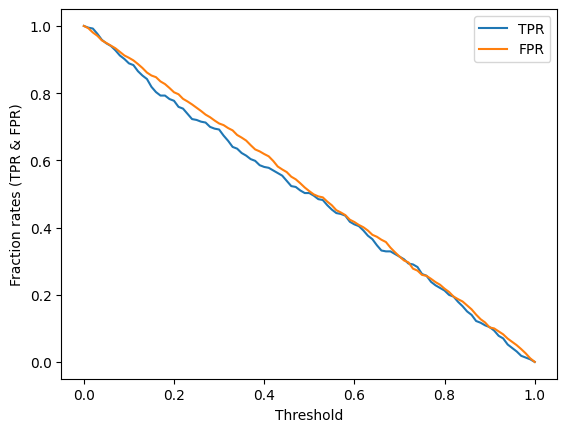

In [33]:
# Plot random model tpr and fpr scores
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.xlabel('Threshold')
plt.ylabel('Fraction rates (TPR & FPR)')
plt.legend()
plt.show()

It is almost a straight line and if we consider the threshold at 0.6, the fraction rates (for TPR and FPR) are 40%. This means that the random model thinks 40% of the time the customer is churning (TPR) and also missing 40% of the time a customer who is not churning (FPR).

In the next benchmark, we want to create an ideal model that predicts every class. In ideal model the values are in order from from smallest (no churn) to largest (churn) and we have an optimal threshold in between these values to predict both classes perfectly. Let's build this model.

### Ideal model

In [34]:
# Extract the number of negative class from y_val
num_neg = (y_val == 0).sum()
# Extract the number of positive class from y_val
num_pos = (y_val == 1).sum()
(num_neg, num_pos)

(1023, 386)

We'll create an array that corresponds exactly to `y_val` and use it for evaluation.

In [35]:
# Create an array of negative and positive class using np.repeat()
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [36]:
# Create y_ideal_pred
y_ideal_pred = np.linspace(0 , 1, len(y_ideal))
y_ideal_pred.round()

array([0., 0., 0., ..., 1., 1., 1.])

In [37]:
# Find optimal threshold where the accuracy is 100%
1 - y_ideal.mean()

0.7260468417317246

In [38]:
# Evaluate y_ideal_pred with y_ideal (set threshold 0.726)
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

The ideal model gives 100% accuracy for negative and positive class when the threshold is 0.726. Let's create dataframe for ideal model and plot its results:

In [39]:
# Dataframe of ideal model
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


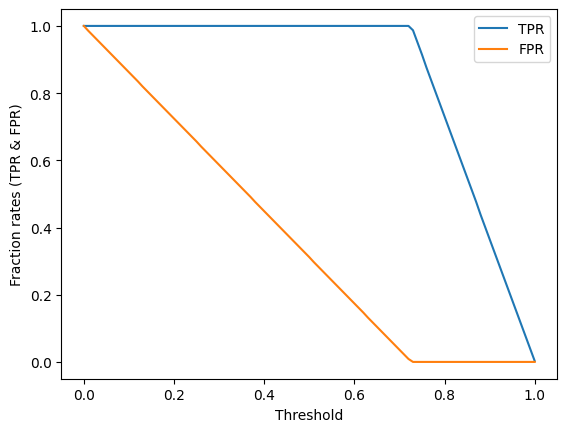

In [40]:
# Plot ideal model tpr and fpr scores
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.xlabel('Threshold')
plt.ylabel('Fraction rates (TPR & FPR)')
plt.legend()
plt.show()

Here we see the TPR stays at 1 and FPR reaches to 0 when the threshold is 0.726 and after that point the model begins to make predictions mistakes again in terms of TPR.

Now what we can do is to plot all the benchmarks together and compare them.

### Putting everything together

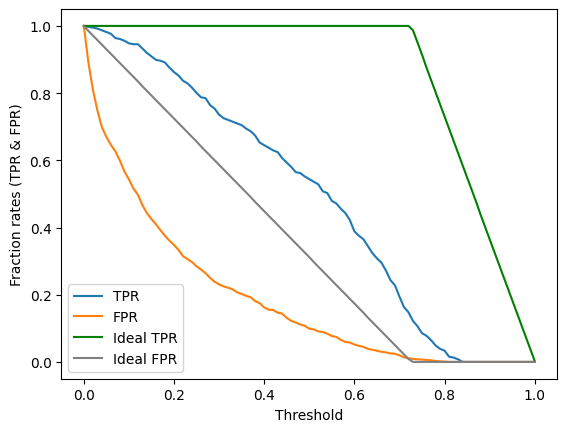

In [41]:
# Plot original model tpr and fpr scores
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')

# # Plot random model tpr and fpr scores
# # We know the random model is just straight line from 
# # 0 to 1 so we can skip it
# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')

# Plot ideal model tpr and fpr scores
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='Ideal TPR', color='green')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='Ideal FPR', color='gray')


plt.xlabel('Threshold')
plt.ylabel('Fraction rates (TPR & FPR)')
plt.legend()
plt.show()

By making comparison we can see that there is quite a big difference between model TPR (blue line) and ideal TPR (green line). We want this line as close as possible.

On the other line the model FPR (orange line) is far below the ideal FRP (gray line).

Ploting against threshold is not always intuitive because for the original model the best accuracy is when threshold is 0.5 and for ideal model it is 0.726. So the best way to analysis the these models is by plotting TPR against FPR.

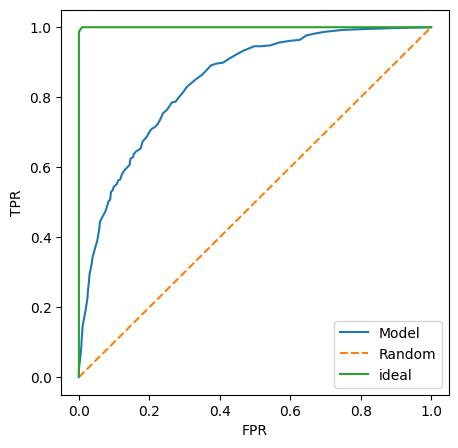

In [42]:
# Make square figure
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
# we know the random model is straight line so we can just plot
# 0 and 1
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

For random model the TPR and FPR is 0 (bottom left) and that's when the threshold is 1. It means the no one is churning and there is not false positives. Whereas, when the threshold is 0 (top right), both TPR and FPR becomes 1 and that means all the customers are churning and all those negative predictions are classified wrong because FPR is 100%.

For Ideal model, as we've previously seen when the threshold is 0.726 we get the 100% TPR and 0% FPR. Which means the ideal model predicted are the positive class (customer who are churning) correctly. The point where the TPR is 100% and FPR is 0% (top left) is called **north star**.

Our goal is to get our model as close as possible to ideal line and far away from the random base line. If we seen our model line goes below the random base line that means there is something wrong and we've made mistakes somewhere.

We can also use sklearn to plot ROC curves:

In [43]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, y_pred)

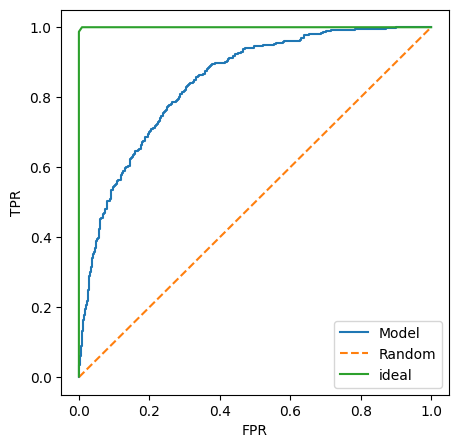

In [44]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model') # fpr, tpr from sklearn
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

Notice the model line has more fluctuation and our custom model line. This is because sklearn compute TPR and FPR with more thresholds which gives us more accuracy results.

ROC curves are useful to see the performance of the model but AUC (Area Under the Curve) matric which is derived from ROC tells us how good our classifier it.

## 4.6 ROC AUC

- Area under the ROC curve - useful metric
- Interpretation of AUC

We can calculate AUC using the sklearn metrics class:

In [45]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(y_val, y_pred) # taken from previous step
auc(fpr, tpr)

0.8438429084426076

In [46]:
# Calculate AUC for df_scores
auc(df_scores.fpr, df_scores.tpr)

0.8437871950323899

Both these scores are same. We can skip the two steps process and calculate AUC directly using sklearn `roc_auc_score()` method, which takes target variable and model predictions as parameters:

In [47]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_val, y_pred)

0.8438429084426076

AUC tells us the probability to randomly selected positive class is greater than negative class. In other words, how well model can order the negative and positive class from smallest to largest.

We can manually implement this using Python and compute the score.

In [48]:
# Extract correctly classified negative class
neg = y_pred[y_val == 0]

# Extract correctly classified positive class
pos = y_pred[y_val == 1]

In [49]:
import random

n = 100000 # number of times to run the loop
success = 0 # how many times possitive class identified as greater than negative class

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1) # len(pos) - 1 to make last element exclusive
    neg_ind = random.randint(0, len(neg) - 1)
    
    if pos[pos_ind] > neg[neg_ind]:
        success += 1
        
success / n

0.84207

We can also compute the auc using NumPy:

In [50]:
np.random.seed(1)

n = 50000
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

0.84646

## 4.7 Cross-Validation

- Evaluating the same model on different subsets of data
- Getting the average prediction and the spread within predictions

We want to create a function `train()` for training the model. The function takes train dataframe and target series for data transformation and train it using logistic regression. The function also takes the hyperparameter `C` that regularize the model to find the optimal value for best results. Higher value of `C` will have lower regularization on the model.

In [51]:
def train(df_train, y_train, C=1.0):
    # Filtering out 'customerid' and 'churn' columns
    # and convert dataframe to dict
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [52]:
# Create the model and fit the train data
dv, model = train(df_train, y_train, C=0.0001)

Next, we'll create another function `predict()` for making predictions. This function takes dataframe (validation or test), dictvectorizer, and the model as parameters, then it transforms data and makes predictions:

In [53]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [54]:
# Make predictions on validation data
y_pred = predict(df_val, dv, model)

In the next step, we'll apply cross-validation (5 folds) and 7 different variation on `C` parameter to calcuation the best AUC curve score along with standard deviation.

In [55]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

n_splits = 5 # kfold split
hyper_list = [0.001, 0.01, 0.1, 0.5, 1, 5, 10] # list of hyperparameters

for C in tqdm(hyper_list): # tqdm to track the status bar on training
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
    scores = [] # list to store C, auc, and std
    
    for train_idx, val_idx in kfold.split(df_full_train): # train + validation sets
        # Extract train and validation data from 'df_full_train'
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        
        # Create target variables
        y_train = df_train.churn.values
        y_val = df_val.churn.values
        
        # Train and predict model on validation data
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        # Calculate AUC on validation
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
    print(f'C: {C}, AUC: {np.mean(scores):.3f}, STD: +-{np.std(scores):.3f}')

  0%|          | 0/7 [00:00<?, ?it/s]

C: 0.001, AUC: 0.825, STD: +-0.009
C: 0.01, AUC: 0.840, STD: +-0.009
C: 0.1, AUC: 0.841, STD: +-0.007
C: 0.5, AUC: 0.840, STD: +-0.007
C: 1, AUC: 0.840, STD: +-0.008
C: 5, AUC: 0.840, STD: +-0.008
C: 10, AUC: 0.841, STD: +-0.008


In our experiement, we can say that `C=0.1` gives us the best AUC score of 0.841 and STD 0.007.

Now we know what is the optimal value to use (`C=0.1`) for model training. We'll now use both train and validation sets (`df_full_train`) to train the model and evaluate it on the test data.

In [56]:
# Train and predict model on test data
dv, model = train(df_full_train, df_full_train.churn, C=0.1)
y_pred = predict(df_test, dv, model)

# Calculate AUC on test
auc = roc_auc_score(y_test, y_pred)
auc

0.85872008623398

The difference between train and test AUC scores is not really big when the hyperparameter is set to 0.1. It means the model is good. If the difference is drastically larger than it'll most likely to be overfitting problem.

**Key note**: When the dataset is large we should probabaly use hold-out validation but when it is small then we can use k-hold validation technique.

## 4.8 Summary

- Metric - a single number that describes the performance of a model
- Accuracy - fraction of correct answers; sometimes misleading
- Precision and recall are less misleading when we have class imbalance
- ROC Curve - a way to evaluate the performance at all thresholds; it is fine to use with imbalance
- K-Fold CV - more reliable estimate for performance (mean + std)

## 4.9 Explore More

- Check the precision and recall of the dummy classifier that always predict "FALSE"
- F1 score = 2 * precision * recall / (precision + recall)
- Evaluate precision and recall at different thresholds, plot Precision vs Recall - this way you'll get the precision/recall curve (similar to ROC curve)
- Area under the PR curve is also a useful metric

Other projects:

- Calculate the metrics for datasets from the previous week

### Calculate Precision and Recall for dummy classifier

To find precision and recall for dummy classifier, we'll split the data into train 80% and test 20% for training and making predictions.

In [57]:
# Split 80% train and 20% test sets
df_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

# Reset indexes
df_full = df_full.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Create target variable for train/test
y_full = df_full.churn.values
y_test = df_test.churn.values

# Delete target valriable churn from features
del df_full['churn']
del df_test['churn']

In [58]:
# Train and predict model on test data
dv, model = train(df_full, y_full)
y_pred = predict(df_test, dv, model)

In the steps below we'll set the threshold to `1.0` so all the predictions become not churning.

In [59]:
# Create arrays to represent actual class labels
actual_positive = y_test == 1
actual_negative = y_test == 0

# Create arrays to represent dummy predicted class labels
# Set threshold to 1.0 to always predict 'False'
t = 1.0
dummy_pred_positive = y_pred >= t
dummy_pred_negative = y_pred < t

# Calculate number of true positive and negative class labels
tp = (dummy_pred_positive & actual_positive).sum()
tn = (dummy_pred_negative & actual_negative).sum()

# Calculate number of false positive and negative class labels
fp = (dummy_pred_positive & actual_negative).sum()
fn = (dummy_pred_negative & actual_positive).sum()

# Create confusion matrix
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])

confusion_matrix

array([[1061,    0],
       [ 348,    0]])

Notice there is no positive class predicted by the dummy model in the confusion matrix. Finally, we'll calculate precision and recall for the dummy classifier.

In [60]:
np.seterr(all="ignore")

# Calculate precision
p = tp / (tp + fp)
p.round(2)

nan

In [61]:
# Calculate recall
r = tp / (tp + fn)
r.round(2)

0.0

The precision score is nan because we can't have 0 in the denominator of a fraction. On the other hand, recall is 0.0 because the fraction 0 divided by 348 is nothing but the 0 itself.

### Calculate Precision and Recall

Precision-Recall curves show how they are depend on each other at different thresholds. For that, we'll plot precision on the y-axis and recall on the x-axis.

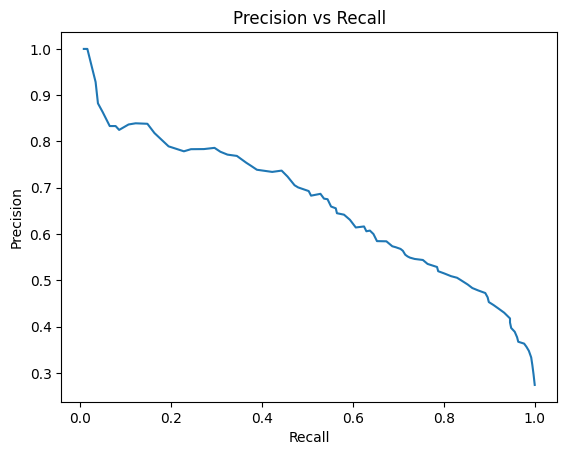

In [62]:
# Calculate and create column for precision and recall
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

# Plot precision vs recall at different thresholds
plt.plot(df_scores.recall, df_scores.precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs Recall')

plt.show()

### Calculate F1

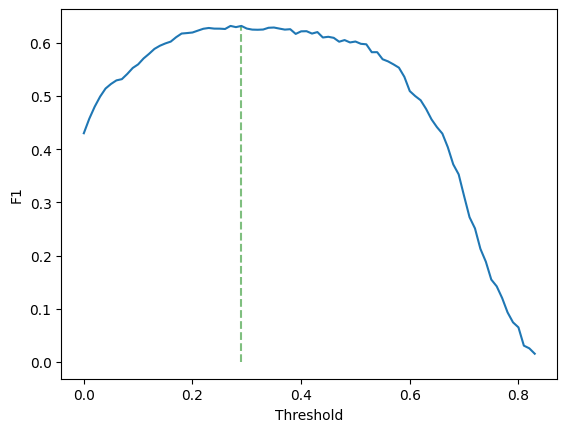

In [63]:
# Calculate and create a column for F1 score
df_scores['f1'] = 2 * df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall)

# Plot f1 score (y-axis) and threshold (x-axis)
plt.plot(df_scores.threshold, df_scores.f1)
plt.xlabel('Threshold')
plt.ylabel('F1')
plt.vlines(0.29, 0, 0.63, color='green', linestyle='--', alpha=0.5)

plt.show()

Around at `0.29` threshold we have the highest f1 score (63%).

### Area under the PR curve

Area under the PR curve is also a useful metric. In order the calculate AUCPR, first we need to check if there is any missing values in `precision` or `recall` column:

In [64]:
# Check the missing values in df_scores
df_scores.isnull().sum()

threshold     0
tp            0
fp            0
fn            0
tn            0
tpr           0
fpr           0
precision    17
recall        0
f1           17
dtype: int64

Indeed precision has 17 missing values. Let's remove them from df_scores dataframe.

In [65]:
# Remove missing values in 'df_scores'
df_scores = df_scores.dropna()

In [66]:
from sklearn.metrics import auc

# Calculate AUCPR
auc(df_scores.recall, df_scores.precision)

0.6588872541502774

The closer AUCPR value is to 1 the better it is. The ideal spot where AUCPR is 1 when PR curve is at (1, 1)